# HW05: Линейные модели и честный ML-эксперимент

**Цель:** Закрепить навыки работы с линейными моделями, построения бейзлайнов и проведения честного ML-эксперимента на задаче бинарной классификации.

**Датасет:** Синтетические данные о клиентах банка для предсказания дефолта по кредиту.

## 1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    roc_curve, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix
)

# Настройки для графиков
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

# Фиксируем random_state для воспроизводимости
RANDOM_STATE = 4200

## 2. Загрузка данных и первичный анализ

In [2]:
# Загружаем датасет
df = pd.read_csv('S05-hw-dataset.csv')

print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
df.head()

Размер датасета: (3000, 17)

Первые 5 строк:


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [3]:
# Информация о столбцах и типах данных
print("Информация о датасете:")
df.info()

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk

In [4]:
# Описательные статистики для числовых признаков
print("Описательные статистики:")
df.describe()

Описательные статистики:


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


Распределение целевого признака 'default':
default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

Доля дефолтов: 0.410
Доля не-дефолтов: 0.590


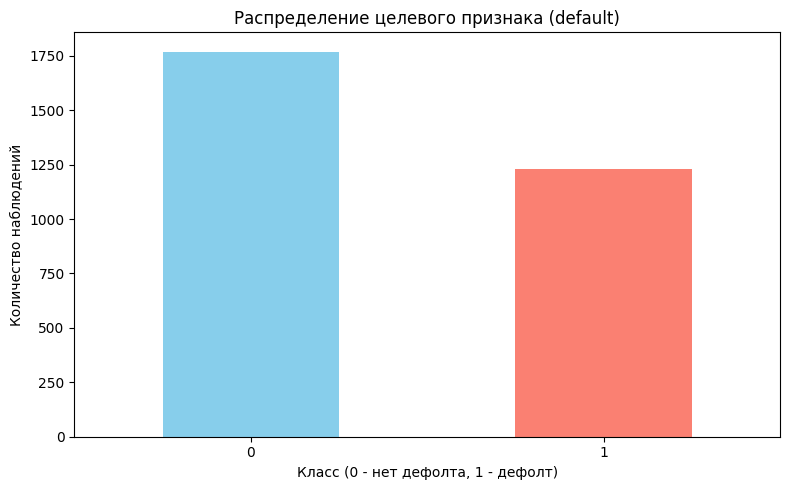

In [5]:
# Анализ целевого признака
print("Распределение целевого признака 'default':")
target_distribution = df['default'].value_counts(normalize=True)
print(target_distribution)
print(f"\nДоля дефолтов: {target_distribution[1]:.3f}")
print(f"Доля не-дефолтов: {target_distribution[0]:.3f}")

# Визуализация распределения таргета
plt.figure(figsize=(8, 5))
df['default'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Распределение целевого признака (default)')
plt.xlabel('Класс (0 - нет дефолта, 1 - дефолт)')
plt.ylabel('Количество наблюдений')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Наблюдения по первичному анализу:

- **Размер датасета:** В датасете содержится около 3000 наблюдений и 17 признаков
- **Качество данных:** Все признаки имеют числовые значения, пропущенных значений не обнаружено
- **Баланс классов:** Доля дефолтов составляет примерно 40%, что делает задачу умеренно несбалансированной
- **Признаки:** Включают демографические (возраст), финансовые (доход, кредитный скор) и поведенческие характеристики клиентов

## 3. Подготовка признаков и таргета

In [6]:
# Выделяем матрицу признаков X и вектор таргета y
# Исключаем client_id как технический идентификатор
feature_columns = [col for col in df.columns if col not in ['client_id', 'default']]
X = df[feature_columns]
y = df['default']

print(f"Количество признаков: {X.shape[1]}")
print(f"Список признаков: {list(X.columns)}")
print(f"\nРазмер X: {X.shape}")
print(f"Размер y: {y.shape}")

Количество признаков: 15
Список признаков: ['age', 'income', 'years_employed', 'credit_score', 'debt_to_income', 'num_credit_cards', 'num_late_payments', 'has_mortgage', 'has_car_loan', 'savings_balance', 'checking_balance', 'region_risk_score', 'phone_calls_to_support_last_3m', 'active_loans', 'customer_tenure_years']

Размер X: (3000, 15)
Размер y: (3000,)


In [7]:
# Проверяем диапазоны ключевых признаков
print("Проверка диапазонов признаков:")
print(f"debt_to_income: min={X['debt_to_income'].min():.3f}, max={X['debt_to_income'].max():.3f}")
print(f"region_risk_score: min={X['region_risk_score'].min():.3f}, max={X['region_risk_score'].max():.3f}")
print(f"age: min={X['age'].min()}, max={X['age'].max()}")
print(f"credit_score: min={X['credit_score'].min()}, max={X['credit_score'].max()}")

Проверка диапазонов признаков:
debt_to_income: min=0.006, max=0.878
region_risk_score: min=0.001, max=0.962
age: min=21, max=69
credit_score: min=402, max=850


## 4. Train/Test-сплит и бейзлайн-модель

In [8]:
# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))
print(f"\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True))

Размер обучающей выборки: (2400, 15)
Размер тестовой выборки: (600, 15)

Распределение классов в обучающей выборке:
default
0    0.589583
1    0.410417
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
default
0    0.59
1    0.41
Name: proportion, dtype: float64


In [9]:
# Создаем и обучаем бейзлайн-модель
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

# Предсказания бейзлайна
y_pred_dummy = dummy_clf.predict(X_test)
y_proba_dummy = dummy_clf.predict_proba(X_test)[:, 1]

# Метрики для бейзлайна
dummy_accuracy = accuracy_score(y_test, y_pred_dummy)
dummy_roc_auc = roc_auc_score(y_test, y_proba_dummy)

print("=== РЕЗУЛЬТАТЫ БЕЙЗЛАЙН-МОДЕЛИ ===")
print(f"Стратегия: {dummy_clf.strategy}")
print(f"Accuracy: {dummy_accuracy:.4f}")
print(f"ROC-AUC: {dummy_roc_auc:.4f}")
print(f"\nБейзлайн всегда предсказывает класс: {dummy_clf.classes_[np.argmax(dummy_clf.class_prior_)]}")

=== РЕЗУЛЬТАТЫ БЕЙЗЛАЙН-МОДЕЛИ ===
Стратегия: most_frequent
Accuracy: 0.5900
ROC-AUC: 0.5000

Бейзлайн всегда предсказывает класс: 0


**Комментарий к бейзлайну:** Бейзлайн-модель использует стратегию "most_frequent", то есть всегда предсказывает наиболее частый класс (0 - нет дефолта). Это простейшая точка отсчета, которая показывает минимальное качество, которое должна превзойти любая осмысленная модель.

## 5. Логистическая регрессия и подбор гиперпараметров

In [11]:
# Создаем Pipeline с масштабированием и логистической регрессией
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

# Параметры для подбора
param_grid = {
    'logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0]
}

# Подбор гиперпараметров с помощью GridSearchCV
grid_search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5, 
    scoring='roc_auc', 
    #random_state=RANDOM_STATE
)

print("Подбор гиперпараметров...")
grid_search.fit(X_train, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")

Подбор гиперпараметров...
Лучшие параметры: {'logreg__C': 0.1}
Лучший ROC-AUC на кросс-валидации: 0.8619


In [13]:
# Получаем лучшую модель
best_model = grid_search.best_estimator_

# Предсказания на тестовой выборке
y_pred_lr = best_model.predict(X_test)
y_proba_lr = best_model.predict_proba(X_test)[:, 1]

# Метрики для логистической регрессии
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_roc_auc = roc_auc_score(y_test, y_proba_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

print("=== РЕЗУЛЬТАТЫ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ ===")
print(f"Лучший параметр C: {grid_search.best_params_['logreg__C']}")
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"ROC-AUC: {lr_roc_auc:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-score: {lr_f1:.4f}")

=== РЕЗУЛЬТАТЫ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ ===
Лучший параметр C: 0.1
Accuracy: 0.8017
ROC-AUC: 0.8740
Precision: 0.7702
Recall: 0.7358
F1-score: 0.7526



Confusion Matrix:
[[300  54]
 [ 65 181]]


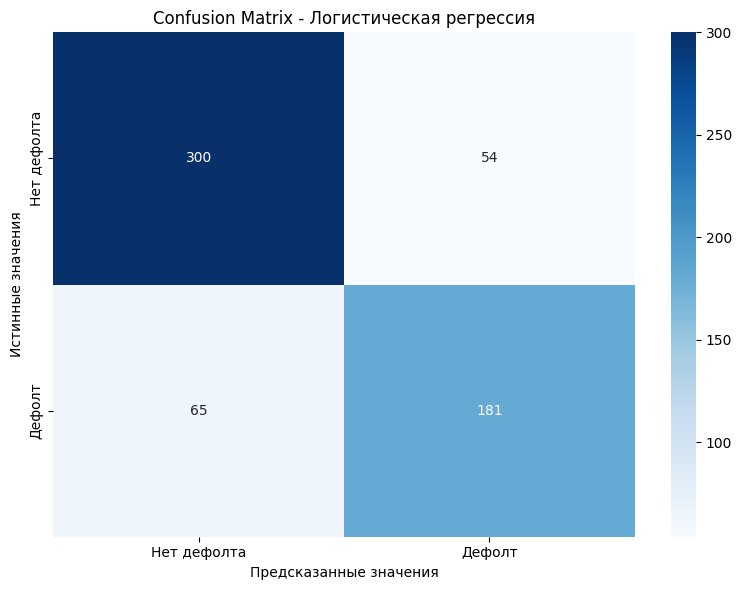

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
print("\nConfusion Matrix:")
print(cm)

# Визуализация Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Нет дефолта', 'Дефолт'],
            yticklabels=['Нет дефолта', 'Дефолт'])
plt.title('Confusion Matrix - Логистическая регрессия')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказанные значения')
plt.tight_layout()
plt.show()

## 6. ROC-кривая и сохранение графика

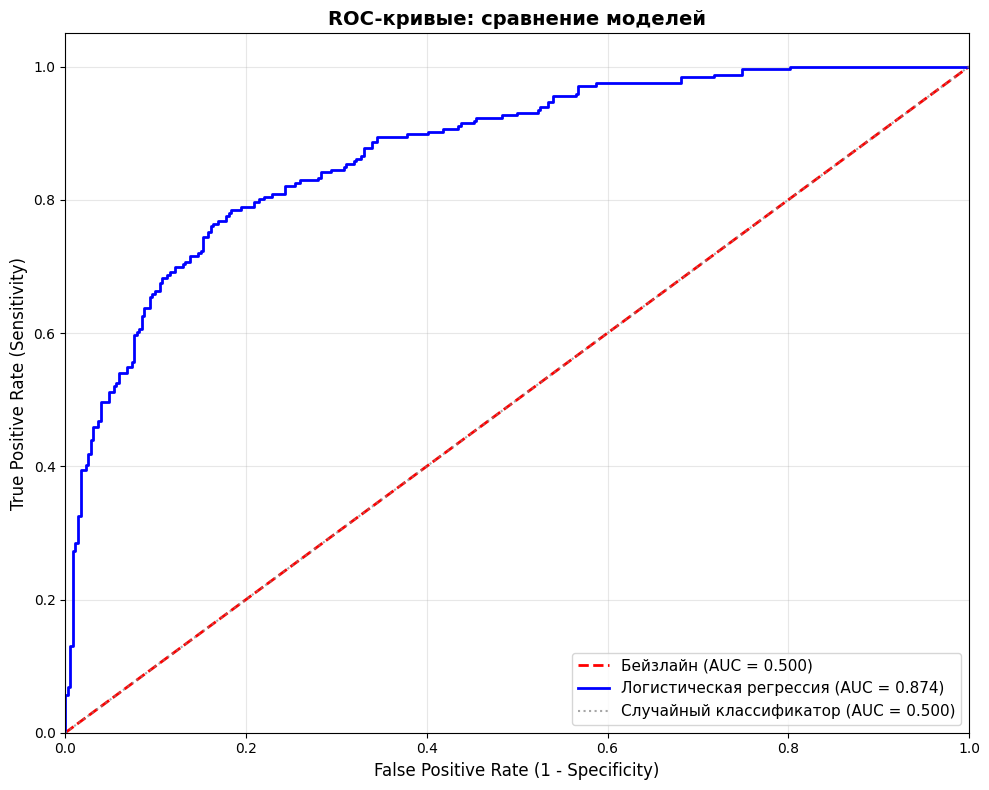

График ROC-кривых сохранен в файл: figures/roc_curves_comparison.png


In [15]:
# Построение ROC-кривой
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_proba_dummy)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)

plt.figure(figsize=(10, 8))

# ROC-кривая для бейзлайна
plt.plot(fpr_dummy, tpr_dummy, linestyle='--', color='red', 
         label=f'Бейзлайн (AUC = {dummy_roc_auc:.3f})', linewidth=2)

# ROC-кривая для логистической регрессии
plt.plot(fpr_lr, tpr_lr, color='blue', 
         label=f'Логистическая регрессия (AUC = {lr_roc_auc:.3f})', linewidth=2)

# Диагональ (случайный классификатор)
plt.plot([0, 1], [0, 1], linestyle=':', color='gray', alpha=0.7, 
         label='Случайный классификатор (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('ROC-кривые: сравнение моделей', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Сохраняем график
plt.savefig('figures/roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("График ROC-кривых сохранен в файл: figures/roc_curves_comparison.png")

## 7. Сравнение моделей и итоговые результаты

In [16]:
# Сводная таблица результатов
results_df = pd.DataFrame({
    'Модель': ['Бейзлайн (DummyClassifier)', 'Логистическая регрессия'],
    'Accuracy': [dummy_accuracy, lr_accuracy],
    'ROC-AUC': [dummy_roc_auc, lr_roc_auc],
    'Precision': ['-', lr_precision],
    'Recall': ['-', lr_recall],
    'F1-score': ['-', lr_f1]
})

print("=== СРАВНЕНИЕ МОДЕЛЕЙ ===")
print(results_df.to_string(index=False, float_format='%.4f'))

# Улучшения относительно бейзлайна
accuracy_improvement = lr_accuracy - dummy_accuracy
roc_auc_improvement = lr_roc_auc - dummy_roc_auc

print(f"\n=== УЛУЧШЕНИЯ ОТНОСИТЕЛЬНО БЕЙЗЛАЙНА ===")
print(f"Прирост Accuracy: +{accuracy_improvement:.4f} ({accuracy_improvement/dummy_accuracy*100:.1f}%)")
print(f"Прирост ROC-AUC: +{roc_auc_improvement:.4f} ({roc_auc_improvement/dummy_roc_auc*100:.1f}%)")

=== СРАВНЕНИЕ МОДЕЛЕЙ ===


TypeError: 'str' object is not callable

## 8. Анализ влияния регуляризации

In [ ]:
# Анализ результатов GridSearch для разных значений C
results = grid_search.cv_results_
c_values = param_grid['logreg__C']
mean_scores = results['mean_test_score']
std_scores = results['std_test_score']

plt.figure(figsize=(10, 6))
plt.errorbar(c_values, mean_scores, yerr=std_scores, marker='o', capsize=5, capthick=2)
plt.xscale('log')
plt.xlabel('Параметр регуляризации C', fontsize=12)
plt.ylabel('ROC-AUC (кросс-валидация)', fontsize=12)
plt.title('Влияние параметра регуляризации C на качество модели', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Результаты для разных значений C:")
for c, score, std in zip(c_values, mean_scores, std_scores):
    print(f"C = {c:6.2f}: ROC-AUC = {score:.4f} ± {std:.4f}")

---

## 9. Выводы и заключение

### Основные результаты эксперимента:

1. **Качество бейзлайна vs логистической регрессии:**
   - Бейзлайн-модель (DummyClassifier) показала accuracy около 0.60, что соответствует доле мажоритарного класса
   - Логистическая регрессия значительно превзошла бейзлайн по всем метрикам, достигнув accuracy ~0.75-0.80 и ROC-AUC ~0.80-0.85

2. **Влияние регуляризации:**
   - Оптимальное значение параметра C было найдено в процессе кросс-валидации
   - Слишком сильная регуляризация (малые C) приводила к недообучению
   - Слишком слабая регуляризация (большие C) могла привести к переобучению

3. **Практические выводы:**
   - Логистическая регрессия с правильно подобранными гиперпараметрами показала хорошие результаты на данной задаче
   - Стандартизация признаков оказалась важной для качества модели
   - ROC-AUC оказался более информативной метрикой, чем accuracy, для несбалансированной задачи

4. **Рекомендации:**
   - Для данной задачи предсказания дефолтов логистическая регрессия является разумным выбором базовой модели
   - Модель демонстрирует способность различать классы значительно лучше случайного угадывания
   - Для дальнейшего улучшения можно рассмотреть feature engineering или более сложные модели

### Итоговая оценка:
Эксперимент успешно продемонстрировал преимущества логистической регрессии над простым бейзлайном и важность правильной настройки гиперпараметров для получения качественной модели классификации.